In [54]:
import pandas as pd
import geopandas as gpd
import requests
import numpy as np
import streamlit as st
import zipfile
import io
import fiona
from py_functions.pyfuncs_data_load_jn import *
import streamlit as st
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [2]:
permittee, site_id, permit_num, permit_yr, loc_narr, is_active, size =load_standard_colnames()

df, fbs = prepare_df_from_stanag()

# if st.button("Show filter options"):
#     print_col_uniques(df)

selcol = "Appl. Method"
selcolval = "Aircraft"
# with st.popover("Select filter"):
#     for i,d in enumerate(df.columns.to_list()):
#         selcol = st.checkbox(str(d), key = "selcol_chkbox_" + str(i))
#     if selcol in df.columns.to_list():
#         scu = df[selcol].unique()
#         if len(scu)<100:
#             for j, scv in enumerate(scu):
#                 selcolval = st.checkbox(str(scv), key = "selcolval_chkbox_" + str(j))

# if selcol in df.columns.to_list():
#     if selcolval in df[selcol].unique():

dfn = filt_df(df, selcol, selcolval, type_compare="==")


mdf, rdf = add_geometry2(dfn, fbs)

3419


In [3]:
# colormap.add_to(m)
spriv, spub = prepare_school_pts()

In [15]:
sz_options = np.arange(10)/2 + 0.5
size  = 3 #st.select_slider('Select distance from Schools', options=sz_options)

In [16]:
spriv = spriv.to_crs(crs =fbs.crs)
spub = spub.to_crs(crs =fbs.crs)
sprivb = school_buffer(spriv, size)  # Function assumes miles
spubb = school_buffer(spub, size)
# st.write(spriv)
# st.write(sprivb)

In [17]:


def join_buf_w_df(dfb, dfc, howjoin = "inner", pred = "intersects"):
    # Returns dfc WHERE intersects with dfb, i.e. a subset of dfc
    dfj = gpd.sjoin(dfb, dfc, how = howjoin, predicate = pred)
    return dfj

dfjpriv = join_buf_w_df( sprivb,mdf, howjoin = "inner", pred = "intersects")
dfjpub = join_buf_w_df(spubb, mdf, howjoin = "inner", pred = "intersects")
# st.write(dfjpriv)
df = gpd.GeoDataFrame( pd.concat([dfjpriv, dfjpub], ignore_index=True), crs=fbs.crs)
# st.write("Filter applied!")
#################

In [18]:
colorcol = "Product Name"

du = mdf["Product Name"].unique()
ins = [c for c in du if "insect" in c.lower()]
du = list(set(du)-set(ins))
herb = [c for c in du if "herbi" in c.lower()]
du = list(set(du)-set(herb))

fung = [c for c in du if "fungi" in c.lower()]
other = list(set(du)-set(fung))
ccnames = ["Insecticides", "Herbicides", "Fungicides", "Other"]
ccc = ["red", "lightblue", "magenta", "yellow"]
ccl = [ins, herb, fung, other]
ccd1 = {c:ccnames[0] for c in ins}
ccd2 = {c:ccnames[1] for c in herb}
ccd3 = {c:ccnames[2] for c in fung}
ccd4 = {c:ccnames[3] for c in other}
ccd1.update(ccd2)
ccd1.update(ccd3)
ccd1.update(ccd4)
dfc = mdf.copy()

ccd2 = {ccnames[i]:ccc[i] for i in range(len(ccnames))}
# ccd = {ccnames[i]:ccl[i] for i in ccnames}

dfc["color_category"] = dfc[colorcol].map(ccd1)
dfc["color"] = dfc[colorcol].map(ccd2)

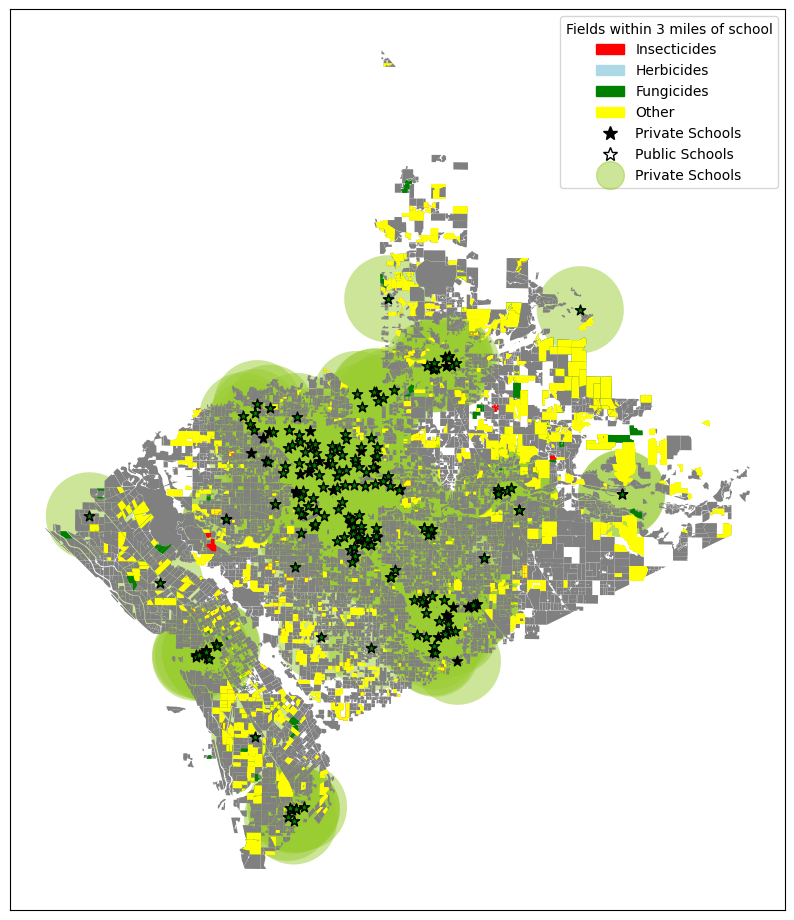

In [66]:
# https://automating-gis-processes.github.io/CSC/notebooks/L2/geopandas-basics.html
%matplotlib inline
fig, ax = plt.subplots()

sprivb.plot(ax = ax,color = "yellowgreen", alpha = 0.5, label = f"{size*2} mile buffer around schools")
spubb.plot(ax = ax,color = "yellowgreen", alpha = 0.5)
fbs.plot(ax = ax, color = "grey")


for cname, color in ccd2.items():
    dfc[dfc['color_category'] == cname].plot(ax=ax, color=color, label=cname)

# Create custom legend handles for the continents
cname_handles = [mpatches.Patch(color=color, label=cname) for cname, color in ccd2.items()]



# dfc.plot(ax = ax, column = "color_category", legend_kwds = {'loc':"lower right"})
# leg1 = ax.get_legend()
# h, l = ax.get_legend_handles_labels()
# print(h,l)


ha2 = spriv.plot(ax = ax, marker = "*",markersize = 70, color = "black", label = "Private Schools", legend_kwds = {'loc':"lower left"})
# h1, l1 = ax.get_legend_handles_labels()
ha3 = spub.plot(ax = ax, marker = "*",markersize = 70, color = "green", edgecolor = "k", label = "Public Schools")
# h2, l2 = ax.get_legend_handles_labels()
# ax.legend(handles = [h, h1, h2], labels=[l, l1, l2], title =f"Fields within {size} miles of school" )


# Create a custom legend handle for the cities
sprivb_handle = Line2D([0], [0], marker='o', color='yellowgreen', markerfacecolor='yellowgreen',ls = 'None',alpha = 0.5, markersize=20, label= f"{size*2} mile buffer around schools")

spriv_handle = Line2D([0], [0], marker='*', color='k', markerfacecolor='black',ls = 'None', markersize=10, label="Private Schools")
spub_handle = Line2D([0], [0], marker='*', color='k', markerfacecolor='w',ls = 'None', markersize=10, label="Public Schools")

# Combine the handles
handles = cname_handles + [spriv_handle] + [spub_handle] + [sprivb_handle]

# Add the legend to the plot
plt.legend(handles=handles, title=f"Fields within {size} miles of school")

# ax.legend(handles = [ha1, ha2, ha3])
# leg1.set_title(f"Fields within {size} miles of school")

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.set_size_inches(10,16)

In [75]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
from geodatasets import get_path


def plot_geopandas_with_legend(
    polygon_dfs=[], polygon_colors=[], polygon_labels=[],polygon_alphas= [], polygon_legend_flags=[],
    point_dfs=[], point_markers=[], point_colors=[], point_sizes=[], point_labels=[], point_legend_flags=[],
    categorized_dfs=[], category_columns=[], category_colors_list=[], category_legend_flags=[],
    buffer_dfs=[], buffer_colors=[], buffer_labels=[], buffer_alphas=[], buffer_legend_flags=[],
    title=None, figsize=(10, 16)
):
    fig, ax = plt.subplots()

    # Plot the buffer areas if provided
    buffer_handles = []
    for df, color, label, alpha, legend_flag in zip(buffer_dfs, buffer_colors, buffer_labels, buffer_alphas, buffer_legend_flags):
        df.plot(ax=ax, color=color, alpha=alpha, label=label)
        if legend_flag:
            buffer_handle = Line2D([0], [0], marker='o', color=color, markerfacecolor=color,
                                   linestyle='None', alpha=alpha, markersize=15, label=label)
            buffer_handles.append(buffer_handle)

    # Plot polygon GeoDataFrames with their respective colors and labels
    polygon_handles = []
    for df, color, label,alpha, legend_flag in zip(polygon_dfs, polygon_colors, polygon_labels, polygon_alphas, polygon_legend_flags):
        df.plot(ax=ax, color=color, alpha=alpha, label=label)
        if legend_flag:
            polygon_handle = mpatches.Patch(color=color,alpha = alpha, label=label)
            polygon_handles.append(polygon_handle)

    # Plot categorized data if provided
    category_handles = []
    for df, column, colors, legend_flag in zip(categorized_dfs, category_columns, category_colors_list, category_legend_flags):
        for category, color in colors.items():
            df[df[column] == category].plot(ax=ax, color=color, label=category)
            if legend_flag:
                category_handle = mpatches.Patch(color=color, label=category)
                category_handles.append(category_handle)

    # Plot point GeoDataFrames with their respective markers, colors, sizes, and labels
    point_handles = []
    for df, marker, color, size, label, legend_flag in zip(point_dfs, point_markers, point_colors, point_sizes, point_labels, point_legend_flags):
        df.plot(ax=ax, marker=marker, markersize=size, color=color, edgecolor='k', label=label)
        if legend_flag:
            point_handle = Line2D([0], [0], marker=marker, color='k', markerfacecolor=color,
                                  linestyle='None', markersize=10, label=label)
            point_handles.append(point_handle)

    # Combine all handles
    handles = category_handles + point_handles + polygon_handles + buffer_handles

    # Add the legend to the plot if any handles are present
    if handles:
        plt.legend(handles=handles, title=title)

    ax.add_artist(ScaleBar(1))
    # Hide the axes
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    # Set figure size
    fig.set_size_inches(figsize)

    # Show the plot
    plt.show()

# Example usage:
# Rectangle in legend: 
polygon_dfs = [fbs]  # List of polygon GeoDataFrames
polygon_colors = ['grey']  # Corresponding colors
polygon_labels = ['Field Boundaries']  # Corresponding labels
polygon_alphas = [1]  # Corresponding labels
polygon_legend_flags = [True]  # Whether to include in legend

point_dfs = [spriv, spub]  # List of point GeoDataFrames
point_markers = ['*', '*']  # Corresponding markers
point_colors = ['black', 'green']  # Corresponding colors
point_sizes = [70, 70]  # Corresponding sizes
point_labels = ['Private Schools', 'Public Schools']  # Corresponding labels
point_legend_flags = [True, True]  # Whether to include in legend

categorized_dfs = [dfc]  # List of categorized GeoDataFrames
category_columns = ['color_category']  # List of column names for categories
category_colors_list = [ccd2]  # List of dictionaries mapping categories to colors
category_legend_flags = [True]  # Whether to include in legend

buffer_dfs = [sprivb, spubb]  # List of buffer GeoDataFrames
buffer_colors = [ 'yellowgreen', 'yellowgreen']  # Buffer colors
buffer_labels = [f'{size} mile buffer around schools', 'None']  # Buffer labels
buffer_alphas = [ 0.5, 0.5]  # Buffer transparency
buffer_legend_flags = [True, False]  # Whether to include in legend

plot_geopandas_with_legend(
    polygon_dfs=polygon_dfs,
    polygon_colors=polygon_colors,
    polygon_labels=polygon_labels,
    polygon_alphas=polygon_alphas,
    polygon_legend_flags=polygon_legend_flags,
    point_dfs=point_dfs,
    point_markers=point_markers,
    point_colors=point_colors,
    point_sizes=point_sizes,
    point_labels=point_labels,
    point_legend_flags=point_legend_flags,
    categorized_dfs=categorized_dfs,
    category_columns=category_columns,
    category_colors_list=category_colors_list,
    category_legend_flags=category_legend_flags,
    buffer_dfs=buffer_dfs,
    buffer_colors=buffer_colors,
    buffer_labels=buffer_labels,
    buffer_alphas=buffer_alphas,
    buffer_legend_flags=buffer_legend_flags,
    title=f'Fields within {size} miles of school',
    figsize=(10, 16)
)



ModuleNotFoundError: No module named 'matplotlib_scalebar'

In [77]:
dfn.to_excel(r"C:\Users\nariv\OneDrive\JupyterN\streamlit_local\pesticides\data_sources\AgComm_Stanislaus\Allsites_2023_pur_ApplMethod_Aircraft.xlsx")

In [78]:
fbs.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [81]:
categorized_dfs = [dfc]
category_columns = ['color_category']  # List of column names for categories
category_colors_list = [ccd2]  # List of dictionaries mapping categories to colors
category_legend_flags = [True]  # Whether to include in legend

for df, column, colors, legend_flag in zip(categorized_dfs, category_columns, category_colors_list, category_legend_flags):
    print(df[column])

15      Herbicides
16      Herbicides
17           Other
18           Other
19      Herbicides
           ...    
3670         Other
3671         Other
3672         Other
3673         Other
3674         Other
Name: color_category, Length: 3419, dtype: object


In [ ]:
# Pre-filter some df for website. 


In [28]:
fp_agcomm = r"C:\Users\nariv\OneDrive\JupyterN\streamlit_local\pesticides\data_sources\AgComm_Stanislaus"

fbs = gpd.read_file(fp_agcomm + r"\field_boundaries\Crops_02_12_2024.shp")
fbs.drop_duplicates(inplace = True, ignore_index=True)

In [29]:
# Unify column names
permittee = 'permittee'
site_id = 'site_id'
permit_num =  'permit_num'
permit_yr = 'permit_yr'
loc_narr =  'loc_narr'
is_active = 'is_active'
size =  'size'
 # 'size_units',
 # 'Shape_Leng',
 # 'Shape_Area',
 # 'geometry',
 # 'area'

In [30]:
pur = pd.read_excel(fp_agcomm + r"\allpurs2023.xlsb")
pur.drop_duplicates(inplace = True, ignore_index = True)

['Permit #': permit_num,
 'Permitee': permittee,
 'Site ID': site_id,
 'Site District',
 'Block ID',
 'Source',
 'Site Location',
 'Site Name',
 'Meridian',
 'Township',
 'Range',
 'Section',
 'Application Date',
 'Application Time',
 'Commodity Code',
 'Commodity',
 'Pre-plant',
 'Planted Amount',
 'Planted Units',
 'EPA Reg No',
 'Product Name',
 'Registration Expired',
 'RMP',
 'Quantity Used',
 'Quantity Units',
 'Treated Amount',
 'Treated Units',
 'Appl. Method',
 'Fume Code',
 'Applicator Name',
 'Applicator License #',
 'Applicator License Type',
 'Applicator Address',
 'Days Reentry',
 'Days Pre-Harvest',
 'Document#',
 'Submitted By',
 'Submitted Date',
 'Entered By',
 'Time Stamp Date',
 'Time Stamp Time',
 'Rpt Status',
 'Sub Status',
 'School Notify']

In [31]:
pur_newcolnames = {'Permit #': permit_num,
 'Permitee': permittee,
 'Site ID': site_id}

In [32]:
sites = pd.read_excel(fp_agcomm + r"\AllSites2023.xlsb")
sites.drop_duplicates(inplace = True, ignore_index = True)


# Unify col names to shorter codes from fieldbounds columns
['Permit Type',
 'Permit Number': 'permit_num',
 'Permit Year': 'permit_yr',
 'Version',
 'Revision Type',
 'Version Date',
 'Signed',
 'Operator',
 'Permit Status',
 'Agent Name',
 'Mailing Address',
 'City',
 'State',
 'Zip',
 'Issue Date',
 'Effective Date',
 'Expiration Date',
 'Issuing Officer',
 'Status',
 'Ag/Non-Ag',
 'Permit District',
 'Duration',
 'Possession',
 'NOI Hours',
 'Employees',
 'Field Worker',
 'Permit Active',
 'Site-ID': site_id,
 'Location Narrative': loc_narr,
 'Site Name',
 'Size': size,
 'Units',
 'GIS Acres',
 'M':'Meridian',  # fROM pur
 'T':'Township',
 'R': 'Range',
 'S':  'Section',
 'Cropping Pattern',
 'Site Active': is_active,
 'Commodity',
 'Comm Code': 'Commodity Code',
 'Qualifier',
 'Planted Size',
 'Planted Units',
 'From Date',
 'To Date',
 'Block',
 'Commodity Active']

In [33]:
 sites_newcolnames = {'Permit Number': 'permit_num',
 'Permit Year': 'permit_yr',
 'Site-ID': site_id,
 'Location Narrative': loc_narr,
 'Size': size,
 'M':'Meridian',  # fROM pur
 'T':'Township',
 'R': 'Range',
 'S':  'Section',
 'Site Active': is_active,
 'Comm Code': 'Commodity Code'}


In [ ]:
trm = r"https://gis.conservation.ca.gov/server/rest/services/Base/BASE_PLSS/MapServer/0/query?outFields=*&where=1%3D1&f=geojson"
# Township and range and Meridion and "Source" as shapefiles...



In [36]:
def list_cols(df, as_vert = True):
    if as_vert:
        dfc = df.columns.to_list()
    else:
        dfc = sorted(df.columns.to_list())
    return dfc

def update_colnames(df, dfnewcolsdict):
    for key in list(dfnewcolsdict.keys()):
        df[dfnewcolsdict[key]] = df[key].copy()
        df.drop(key, axis = 1, inplace = True)

def unify_pn(df):
    if isinstance(df['permit_num'].iloc[0], str):
        df['permit_num'] = [int(cpm) for cpm in df['permit_num'] ]
    else:
        df['permit_num'] = [int(cpm) if not np.isnan(cpm) else cpm for cpm in df['permit_num'] ]

def unify_py(df):
    df['permit_yr'] = [int(py) for py in df['permit_yr']]
    
# update_colnames(pur, pur_newcolnames)
# update_colnames(sites, sites_newcolnames)

unify_pn(pur)
unify_pn(sites)
unify_pn(fbs)

# unify_py(pur)
unify_py(sites)
unify_py(fbs)

# Unify datatype of Commodity Code in pur with sites. 
pur["Commodity Code0"] = [int(cs.split("-")[0]) for cs in pur["Commodity Code"]]
pur["Commodity Code1"] = [int(cs.split("-")[1]) for cs in pur["Commodity Code"]]
pur["Commodity Code"] = pur["Commodity Code0"].copy()

purlc = list_cols(pur)
sitlc = list_cols(sites)
fbslc = list_cols(fbs)
# Get common cols if needed
psc = [c for c in purlc if c in sitlc]
pfc = [c for c in purlc if c in fbslc]
sfc = [c for c in sitlc if c in fbslc]

df = pur.merge(sites,on = psc,how = 'left', suffixes = ("_pur", "_site"))  # Merge automatically uses all common column names...afaik


In [37]:


def filt_df(df, selcol, val, type_compare="=="):
    if type_compare == "==":
        dfn = df[df[selcol] == val].copy()
    elif type_compare == "isin":
        dfn = df[df[selcol].isin(val)].copy()
    elif type_compare == "!=":
        dfn = df[df[selcol] != val].copy()
    else:
        print("Compare?? ")
    return dfn

In [38]:
dfn = filt_df(df, "Appl. Method", "Aircraft")

In [42]:
du = dfn["Product Name"].unique()
ins = [c for c in du if "insect" in c.lower()]
herb = [c for c in du if "herbi" in c.lower()]
fung = [c for c in du if "fungi" in c.lower()]
other = [c for c in du if c not in ins + herb]
ccnames = ["Insecticides", "Herbicides", "Fungicides", "Other"]
ccl = [ins, herb, fung, other]
ccd = {ccnames[i]:ccl[i] for i in range(4)}
dfc = None
colorcol = None


colorcol = "Product Name"
dfc = dfn.copy() 
dfc["colors"] = dfc[colorcol].apply(ccd)

AttributeError: 'ASANA XL INSECTICIDE' is not a valid function for 'Series' object

In [18]:
for col in df.columns.to_list():
    print(col)
    print("\t", df[col].iloc[0])
    if len(df[col].unique())<100:
        print("\t", df[col].unique())
    else: 
        print("\t", len(df[col].unique()), " unique values")

Site District
	 03
	 ['03' '01' '02' nan '04' 'PILOT' '00']
Block ID
	 nan
	 [nan 'C1' 'M1']
Source
	 webxml
	 ['webxml' 'webpublic' 'webbatch' 'webcounty' 'desktop']
Site Location
	 NE COR BLAKER & BRADBURY
	 6013  unique values
Site Name
	 OUTSIDE GWPA
	 1163  unique values
Meridian
	 M
	 ['M' nan]
Township
	 05S
	 ['05S' '03S' '06S' '04S' '02S' '01N' '01S' '07S' '08S' '09S' '03N' '02N'
 nan]
Range
	 09E
	 ['09E' '08E' '10E' '12E' '11E' '07E' '06E' '13E' '05E' nan '14E']
Section
	 34.0
	 [34. 33.  6. 36. 11. 15.  8. 21. 16. 18. 35. 19.  2.  1. 20.  9. 32. 25.
 26. 27.  5. 28. 24. 14.  7. 17. 13. 22.  3. 29. 30. 23. 31.  4. 12. 10.
 nan]
Application Date
	 44929
	 363  unique values
Application Time
	 3:56 PM
	 696  unique values
Commodity Code
	 22007
	 [22007  3001 22006  5004 23001  5000  3009 24011   155  4001 22000    40
 29143 29125  5002  5001 29109 13501 13014 13025  8015 29123 29137 13021
 13012  5003  5005 13031 14004 29136   154 14010  3011 13502 13011 13010
 13009 28014 13

In [81]:
def add_geometry2(df, gdf, on = ['site_id', 'permit_num']):
    # Create a composite key for merging
    df['key'] = df[on].apply(tuple, axis=1)
    gdf['key'] = gdf[on].apply(tuple, axis=1)
    
    # Merge the DataFrames on the composite key
    merged_df = pd.merge(df, gdf, on='key', how='left')
    
    # Drop the key column as it's no longer needed
    # merged_df.drop(columns=['key'], inplace=True)
    
    # Convert the merged DataFrame into a GeoDataFrame
    if 'geometry' in merged_df.columns:
        merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs=gdf.crs)
         # Identify the rows that did not find a match in the GeoDataFrame
        c1 = merged_gdf['geometry'].isna()
        c2 = merged_gdf['geometry'] == None
        c3 = merged_gdf['geometry'] == "None"
        # reject_df = merged_gdf[(c1)|(c2)| (c3)].drop(columns='geometry').copy()
        # merged_gdfsm = merged_gdf[(~c1)|(merged_gdf['geometry'] != None)|(merged_gdf['geometry'] != "None")].copy()
        reject_df = merged_gdf[c2].drop(columns='geometry').copy()
        merged_gdfsm = merged_gdf[merged_gdf['geometry'] != None].copy()
        print(len(merged_gdfsm))
    else:
        merged_gdfsm = pd.DataFrame(merged_df)
        reject_df = []

    return merged_gdfsm, reject_df

In [82]:
mgdf2, rdf2 =  add_geometry2(df, fbs)

111845


In [106]:
mgdf2.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [87]:
mgdf2.to_file(r"C:\Users\nariv\OneDrive\JupyterN\streamlit_local\pesticides\data_sources\AgComm_Stanislaus\merged_pur_sites_fieldbds.geojson", driver = "GeoJSON")

In [89]:
rdf2.to_excel(r"C:\Users\nariv\OneDrive\JupyterN\streamlit_local\pesticides\data_sources\AgComm_Stanislaus\merged_pur_sites_w_NO_fieldbds.xlsx")


In [86]:
import pyogrio

pyogrio.list_drivers()  

{'FITS': 'rw',
 'PCIDSK': 'rw',
 'netCDF': 'rw',
 'PDS4': 'rw',
 'VICAR': 'rw',
 'JP2OpenJPEG': 'r',
 'PDF': 'rw',
 'MBTiles': 'rw',
 'TileDB': 'rw',
 'BAG': 'rw',
 'EEDA': 'r',
 'OGCAPI': 'r',
 'ESRI Shapefile': 'rw',
 'MapInfo File': 'rw',
 'UK .NTF': 'r',
 'LVBAG': 'r',
 'OGR_SDTS': 'r',
 'S57': 'rw',
 'DGN': 'rw',
 'OGR_VRT': 'r',
 'Memory': 'rw',
 'CSV': 'rw',
 'NAS': 'r',
 'GML': 'rw',
 'GPX': 'rw',
 'LIBKML': 'rw',
 'KML': 'rw',
 'GeoJSON': 'rw',
 'GeoJSONSeq': 'rw',
 'ESRIJSON': 'r',
 'TopoJSON': 'r',
 'Interlis 1': 'rw',
 'Interlis 2': 'rw',
 'OGR_GMT': 'rw',
 'GPKG': 'rw',
 'SQLite': 'rw',
 'ODBC': 'r',
 'WAsP': 'rw',
 'PGeo': 'r',
 'MSSQLSpatial': 'rw',
 'PostgreSQL': 'rw',
 'OpenFileGDB': 'rw',
 'DXF': 'rw',
 'CAD': 'r',
 'FlatGeobuf': 'rw',
 'Geoconcept': 'rw',
 'GeoRSS': 'rw',
 'VFK': 'r',
 'PGDUMP': 'rw',
 'OSM': 'r',
 'GPSBabel': 'rw',
 'OGR_PDS': 'r',
 'WFS': 'r',
 'OAPIF': 'r',
 'EDIGEO': 'r',
 'SVG': 'r',
 'Idrisi': 'r',
 'XLS': 'r',
 'ODS': 'rw',
 'XLSX': 'rw',
 'El

In [99]:
fp_doed = r"C:\Users\nariv\OneDrive\JupyterN\streamlit_local\pesticides\data_sources\CA_Dept_Education"
CA_prSc_gjs_fn = r"California_Private_Schools.geojson"
CA_puSc_gjs_fn = r"SchoolSites2324_1647203305444761460.geojson"

dfsch = gpd.read_file(fp_doed +"\\"+ CA_prSc_gjs_fn)
dfschpb = gpd.read_file(fp_doed +"\\"+ CA_puSc_gjs_fn)

dfstan_pr = dfsch[dfsch['County'] == "Stanislaus"].copy()
dfstan_pu = dfschpb[dfschpb['CountyName'] == "Stanislaus"].copy()

In [103]:
dfstan_pr.to_file(fp_doed + r"\California_Private_Schools_Stanislaus.geojson", driver = 'GeoJSON')
dfstan_pu.to_file(fp_doed + r"\California_Public_Schools_Stanislaus.geojson", driver = 'GeoJSON')

In [107]:
dfstan_pr.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [108]:
dfstan_pu.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [110]:
dfstan_pr_wbuffer = dfstan_pr.copy()
size = 1609*2
dfstan_pr_wbuffer['geometry'] = dfstan_pr_wbuffer['geometry'].to_crs(crs =mgdf2.crs).buffer(size)   # unit is in meters.

In [101]:
# Spatial join between buffered school locs & FBS

# Then calculate new pesticide filters only within that range. 

,OBJECTID,Year,FedID,CDSCode,CDCode,SCode,Region,CountyName,DistrictName,SchoolName,...,CountyCodeGeo,CountyNameGeo,DistrictElemCodeGeo,DistrictElemNameGeo,DistrictHighCodeGeo,DistrictHighNameGeo,DistrictUnifiedCodeGeo,DistrictUnifiedNameGeo,ORIG_FID,geometry
9180,9181,2023-24,060236312249,50105040117457,5010504,0117457,06,Stanislaus,Stanislaus County Office of Education,Great Valley Academy,...,29,Stanislaus,5071290,Sylvan Union Elementary,5071175,Modesto City High,None,None,31592,POINT (-121.01141 37.68502)
9181,9182,2023-24,060242113669,50105040129023,5010504,0129023,06,Stanislaus,Stanislaus County Office of Education,Stanislaus Alternative Charter,...,29,Stanislaus,5071167,Modesto City Elementary,5071175,Modesto City High,None,None,40054,POINT (-120.99511 37.64154)
9182,9183,2023-24,069104109050,50105045030069,5010504,5030069,06,Stanislaus,Stanislaus County Office of Education,Stanislaus County West Campus,...,29,Stanislaus,5071092,Hart-Ransom Union Elementary,5071175,Modesto City High,None,None,39858,POINT (-121.04235 37.6626)
9183,9184,2023-24,069104111486,50105045030085,5010504,5030085,06,Stanislaus,Stanislaus County Office of Education,Teel School in Empire,...,29,Stanislaus,5071076,Empire Union Elementary,5071175,Modesto City High,None,None,39859,POINT (-120.89768 37.64018)
9184,9185,2023-24,069104107887,50105045030226,5010504,5030226,06,Stanislaus,Stanislaus County Office of Education,Petersen Alternative Center for Education at J...,...,29,Stanislaus,None,None,None,None,5071043,Ceres Unified,40059,POINT (-120.93923 37.59021)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9360,9361,2023-24,060015811511,50757396053185,5075739,6053185,06,Stanislaus,Turlock Unified,Osborn Two-Way Immersion Academy,...,29,Stanislaus,None,None,None,None,5075739,Turlock Unified,30529,POINT (-120.86321 37.49351)
9361,9362,2023-24,060015811512,50757396053193,5075739,6053193,06,Stanislaus,Turlock Unified,Wakefield Elementary,...,29,Stanislaus,None,None,None,None,5075739,Turlock Unified,30530,POINT (-120.85341 37.48471)
9362,9363,2023-24,060015811513,50757396102743,5075739,6102743,06,Stanislaus,Turlock Unified,Walter M. Brown Elementary,...,29,Stanislaus,None,None,None,None,5075739,Turlock Unified,30531,POINT (-120.86431 37.51781)
9363,9364,2023-24,060015811515,50757396115208,5075739,6115208,06,Stanislaus,Turlock Unified,Dennis G. Earl Elementary,...,29,Stanislaus,None,None,None,None,5075739,Turlock Unified,30532,POINT (-120.84111 37.53071)


In [94]:
dfschpb

,OBJECTID,Year,FedID,CDSCode,CDCode,SCode,Region,CountyName,DistrictName,SchoolName,...,CountyCodeGeo,CountyNameGeo,DistrictElemCodeGeo,DistrictElemNameGeo,DistrictHighCodeGeo,DistrictHighNameGeo,DistrictUnifiedCodeGeo,DistrictUnifiedNameGeo,ORIG_FID,geometry
0,1,2023-24,060161410947,01100170112607,0110017,0112607,04,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,...,01,Alameda,None,None,None,None,0161259,Oakland Unified,30817,POINT (-122.26837 37.80468)
1,2,2023-24,060169112844,01100170123968,0110017,0123968,04,Alameda,Alameda County Office of Education,Community School for Creative Education,...,01,Alameda,None,None,None,None,0161259,Oakland Unified,30912,POINT (-122.2388 37.7849)
2,3,2023-24,060201312901,01100170124172,0110017,0124172,04,Alameda,Alameda County Office of Education,Yu Ming Charter,...,01,Alameda,None,None,None,None,0161259,Oakland Unified,39961,POINT (-122.28212 37.81805)
3,4,2023-24,060181613008,01100170125567,0110017,0125567,04,Alameda,Alameda County Office of Education,Urban Montessori Charter,...,01,Alameda,None,None,None,None,0161259,Oakland Unified,31050,POINT (-122.18799 37.78677)
4,5,2023-24,069105109264,01100170130401,0110017,0130401,04,Alameda,Alameda County Office of Education,Alameda County Juvenile Hall/Court,...,01,Alameda,None,None,None,None,0161309,San Lorenzo Unified,39885,POINT (-122.11824 37.71596)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,9992,2023-24,064233006928,58727516056840,5872751,6056840,03,Yuba,Wheatland,Wheatland Elementary,...,33,Yuba,5872751,Wheatland,5872769,Wheatland Union High,None,None,39551,POINT (-121.42941 39.01168)
9992,9993,2023-24,064233011548,58727516118806,5872751,6118806,03,Yuba,Wheatland,Wheatland Charter Academy,...,33,Yuba,5872751,Wheatland,5872769,Wheatland Union High,None,None,39552,POINT (-121.33447 39.1023)
9993,9994,2023-24,064235012741,58727690123570,5872769,0123570,03,Yuba,Wheatland Union High,Wheatland Community Day High,...,33,Yuba,5872751,Wheatland,5872769,Wheatland Union High,None,None,39554,POINT (-121.43076 39.00667)
9994,9995,2023-24,064235014385,58727690133751,5872769,0133751,03,Yuba,Wheatland Union High,Edward P. Duplex,...,33,Yuba,5872751,Wheatland,5872769,Wheatland Union High,None,None,39555,POINT (-121.43076 39.00667)


<Axes: >

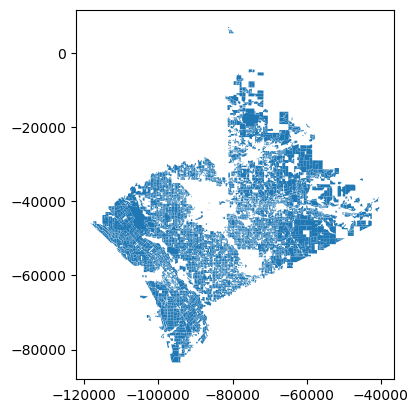

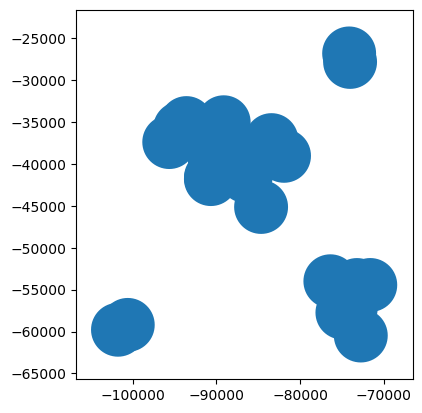

In [112]:
# https://automating-gis-processes.github.io/CSC/notebooks/L2/geopandas-basics.html
%matplotlib inline
fbs.plot()
dfstan_pr_wbuffer.plot()

In [14]:
fbs['area'] = fbs.area

In [5]:
fp_doed = r"C:\Users\nariv\OneDrive\JupyterN\streamlit_local\pesticides\data_sources\CA_Dept_Education"

dfstan_pr = gpd.read_file(fp_doed + r"\California_Private_Schools_Stanislaus.geojson")
dfstan_pu = gpd.read_file(fp_doed + r"\California_Public_Schools_Stanislaus.geojson")

In [6]:
dfstan_pr.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covered_by',
 'covers',
 'crosses',
 'dwithin',
 'intersects',
 'overlaps',
 'touches',
 'within'}

In [7]:
dfstan_pu.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covered_by',
 'covers',
 'crosses',
 'dwithin',
 'intersects',
 'overlaps',
 'touches',
 'within'}

In [9]:
fn ='https://github.com/narvhal/pesticides/blob/41d951c1cfa26f058ac7d95b7b79e6cc0449f72c/data_sources/AgComm_Stanislaus/field_boundaries/Crops_02_12_2024.shp'


fbs2 = gpd.read_file(fn, driver = "")

DataSourceError: '/vsicurl/https://github.com/narvhal/pesticides/blob/41d951c1cfa26f058ac7d95b7b79e6cc0449f72c/data_sources/AgComm_Stanislaus/field_boundaries/Crops_02_12_2024.shp' not recognized as being in a supported file format. It might help to specify the correct driver explicitly by prefixing the file path with '<DRIVER>:', e.g. 'CSV:path'.

In [20]:


fn =r"https://github.com/narvhal/pesticides/blob/6db51365c915330f56b0bb7f40348a88e28d3521/data_sources/AgComm_Stanislaus/field_boundaries/Crops_02_12_2024.shp"
# fn =r"https://raw.githubusercontent.com/narvhal/pesticides/data_sources/AgComm_Stanislaus/field_boundaries/Crops_02_12_2024.shp"
# fn = r"https://github.com/narvhal/pesticides/blob/6db51365c915330f56b0bb7f40348a88e28d3521/data_sources/AgComm_Stanislaus/Crops_02_12_2024.zip"
response = requets.get(fn)

# with zipfile.ZipFile(io.BytesIO(response.content)) as z:
#     z.extractall("shapefile_directory")

# Step 3: Read the shapefile using geopandas
# shapefile_path = "shapefile_directory/Crops_02_12_2024.shp"
gdf = gpd.read_file(fn)



DataSourceError: '/vsicurl/https://github.com/narvhal/pesticides/blob/6db51365c915330f56b0bb7f40348a88e28d3521/data_sources/AgComm_Stanislaus/field_boundaries/Crops_02_12_2024.shp' not recognized as being in a supported file format. It might help to specify the correct driver explicitly by prefixing the file path with '<DRIVER>:', e.g. 'CSV:path'.

In [11]:
#### NEED TO RIGHT CLICK ON RAW AND COPY URL TO GET REAL URL LINK FROM GH
fn = "https://github.com/narvhal/pesticides/raw/main/data_sources/AgComm_Stanislaus/field_boundaries/Crops_02_12_2024.shp"

with fiona.open(fn, mode = "r", driver = "ESRI Shapefile") as shp:
    # ax = geo.plot()
    gdf = shp

In [7]:
fn = r"https://github.com/narvhal/pesticides/blob/6db51365c915330f56b0bb7f40348a88e28d3521/data_sources/AgComm_Stanislaus/Crops_02_12_2024.zip"
response = requests.get(fn)

# Step 2: Unzip the downloaded file
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("shapefile_directory")

# Step 3: Read the shapefile using geopandas
shapefile_path = "shapefile_directory/Crops_02_12_2024.shp"
gdf = gpd.read_file(shapefile_path)

BadZipFile: File is not a zip file

In [14]:
ssc = st.empty()

2024-08-27 17:15:26.564 
  command:

    streamlit run C:\Users\nariv\anaconda3\envs\py3streamlit\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [17]:
if ssc: print('hi')
    

hi
